# Differential Expression Analysis

General review:

https://genomebiology.biomedcentral.com/articles/10.1186/gb-2003-4-4-210

(doi:10.1186/gb-2003-4-4-210)

In [8]:
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  

In [104]:
import urllib
from numpy import random
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats as stats
from scipy.stats import zscore
import pylab 
import statsmodels.api as sm
from statsmodels.sandbox.stats.multicomp import multipletests

We want to do statistical tests for differential expression in cDNA microarray experiments to identify differentially expressed genes. Obviously we need to start downloading the data:

In [63]:
# download the data
urllib.urlretrieve("http://science.sciencemag.org/highwire/filestream/680254/field_highwire_adjunct_files/5/aad0189_DataFileS5.xlsx", 
                   "data/microarray.xlsx");

After we've downloaded the data we need to read it in and take a short look on it in order to work with it. 

In [64]:
# Read in aad0189_DataFileS5.xlsx with pandas
microarray_data = pd.read_excel("data/microarray.xlsx", na_values='x', header=2)

# Average over different probesets for a gene and generate a dataframe containing each gene symbol (once) as rows 
# and the corresponding averaged expression values for each strain + condition as columns:
mean_values = microarray_data.groupby("Gene").mean()

## Quantile normalization 
To figure out whether we need to carry out a quantile normalization of the data we will create a ratio intensity plot for several pair of chips and a relative log expression plot. If the data is already normalized we won't have to do quantile normalization. 

In [76]:
def ratio_intensity_plot(ratio_intens_data_df, sample1, sample2):
    ''' This function creates the ratio-intensity-plot for two series
    
        sample1: Series 1
        sample2: Series 2
    '''
    
    
    # get the expression data
    expr_sample_1 = ratio_intens_data_df[sample1]
    expr_sample_2 = ratio_intens_data_df[sample2]
    
    # calculate ratio and intensity
    R = np.log(expr_sample_1 / expr_sample_2)
    I = (np.log(expr_sample_1) + np.log(expr_sample_2))/2
    
    # plot intensity vs ratio
    plt.scatter(I,R)
    plt.title(sample1 + " vs. " + sample2)
    plt.xlabel("Average log intensity")
    plt.ylabel("log intensity ratio")
    plt.axhline(color="red") 

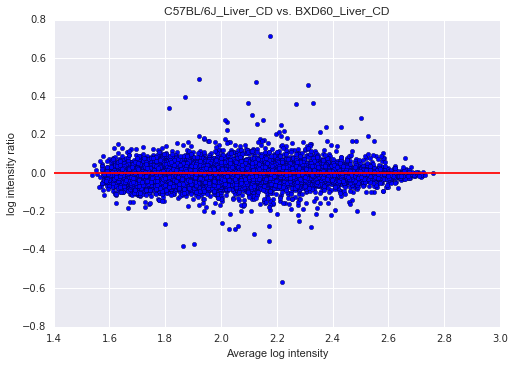

In [78]:
# Apply your ratio intensity plot to several pairs of chips 
ratio_intensity_plot(mean_values, 'C57BL/6J_Liver_CD', 'BXD60_Liver_CD')

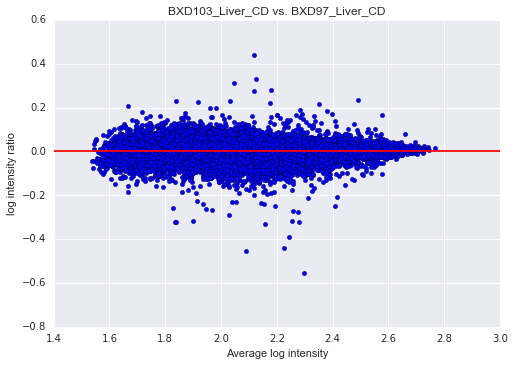

In [79]:
# Apply your ratio intensity plot to several pairs of chips 
ratio_intensity_plot(mean_values, 'BXD103_Liver_CD', 'BXD97_Liver_CD')

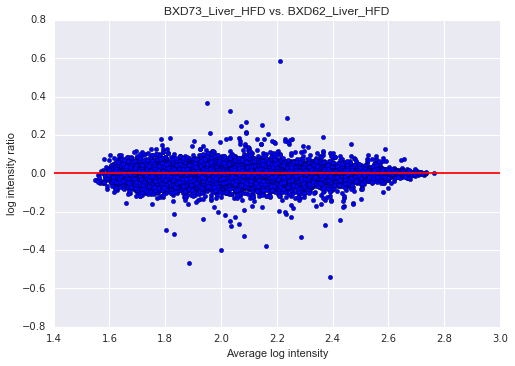

In [80]:
# Apply your ratio intensity plot to several pairs of chips 
ratio_intensity_plot(mean_values, 'BXD73_Liver_HFD', 'BXD62_Liver_HFD')

The ratio intensity plots indicate that the data is already normalized, but to be sure we want to check it for each measurement and create a relative log expression plot to so.

In [83]:
def rle_plot(rle_data, cols):
    ''' This function creates a rle plot (e.g. rle_plot(microarray_data, microarray_data.columns[10:15]) ) . 
    
        rle_data: dataframe containing the data
        cols: dataframe containing the columns 
    
    '''
    
    # for any gene calculate the median across all samples
    rle_data_median = rle_data[cols].stack().median()
    
    # for a given sample divide the expression values by the corresponding mean
    rle_data_boxplot = rle_data[cols] / rle_data_median
    
    # change size
    plt.figure(figsize=(16,9))
    plt.title("RLE plot of the microarray data")
    plt.xticks(rotation=90)
    
    # for every sample plot a box plot
    sns.boxplot(data=np.log(rle_data_boxplot))

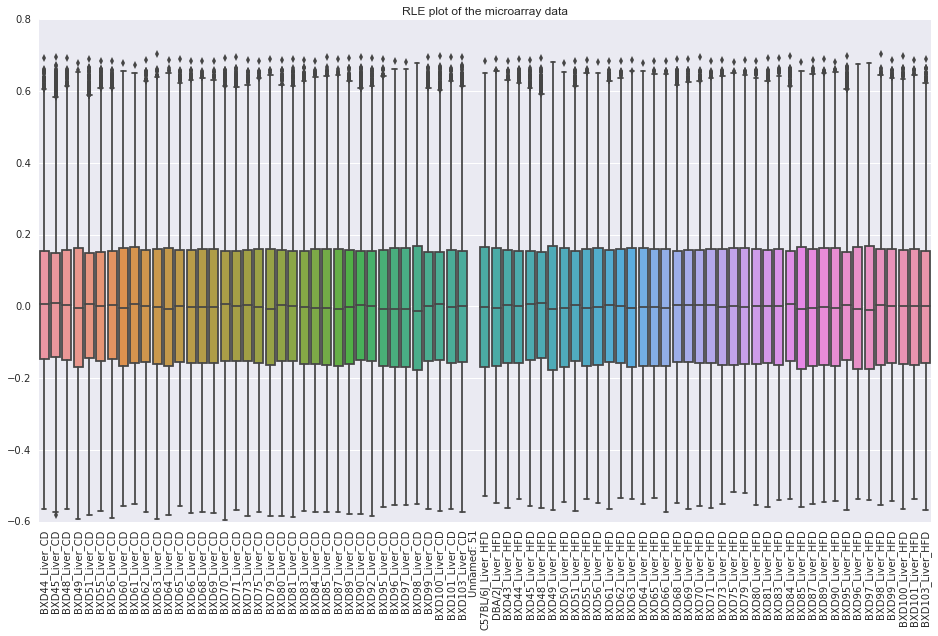

In [84]:
# Apply your RLE plot to the data
# microarray_data.columns[10:]: the expression values start at column 10
rle_plot(mean_values, mean_values.columns[10:])

The RLE plot affirmes our assumption. Normalization is not necessary, since the data is already normalized.

## Statistical tests

We want to infer differentially expressed genes between the CD and the HFD condition. Therefore we (mis)(?)treat (!) the (already) normalized expression values of all the strains for a given condition as independent observations of the same sample. But first we need to figure out which statistical test for differential expression seems appropriate (concerning distribution and variance assumptions) and then apply it. Limit yourself to the Student t-test, the Welch t-test or Wilcoxon's rank-sum test (also sometimes refered to as Whitney-Mann U-test).

### Equal variance
We will start checking the samples for equal variance.

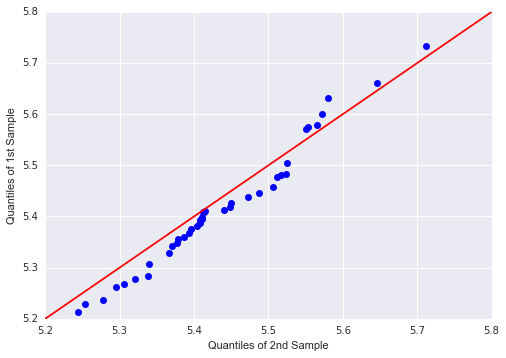

In [90]:
# Choose a random row of your latest dataframe
random_row = mean_values.iloc[np.random.randint(mean_values.shape[0])]

# Make a Q-Q plot comparing the two samples for the just chosen gene
# BXD92_Liver_CD exists only for CD -> remove it 
random_row_dropped = random_row.drop('BXD92_Liver_CD')

# get the CD and HFD expression values
sample_CD_expr_values = random_row_dropped[48:]
sample_HFD_expr_values = random_row_dropped[7:47]

# qq plot for CD and HFD
sm.qqplot_2samples(sample_CD_expr_values, sample_HFD_expr_values, line='45');

In [91]:
# Apply an appropriate statistical test in order to figure out whether the samples have equal variance
stats.bartlett(sample_CD_expr_values, sample_HFD_expr_values)

BartlettResult(statistic=0.79359707566882964, pvalue=0.37301466028358343)

To asses the global situation we will plot a histogram of p-values for all the genes.

In [23]:
def global_test_equal_variance(data_df):
    ''' This function tests for equal variance for the given dataframe (= applies bartlett test to each row).
    
        data_df: the dataframe to test for
    
    '''
    
    # list to store the result
    list_of_p_values_ = []
    
    # iterate over the dataframe
    for row_ in data_df.index:
        
        # get the current row
        gene_ = microarray_data.loc[row_]
        
        # BXD92_Liver_CD exists only for CD -> remove it 
        gene_dropped = gene_.drop('BXD92_Liver_CD')

        # get the CD and HFD expression values
        sample_CD_expr_values_ = gene_dropped[51:]
        sample_HFD_expr_values_ = gene_dropped[10:50]
        
        # apply bartlett test:
        list_of_p_values_.append(stats.bartlett(sample_CD_expr_values_, sample_HFD_expr_values_)[1])
        
    return list_of_p_values_    
        

In [24]:
global_p_values = global_test_equal_variance(microarray_data)

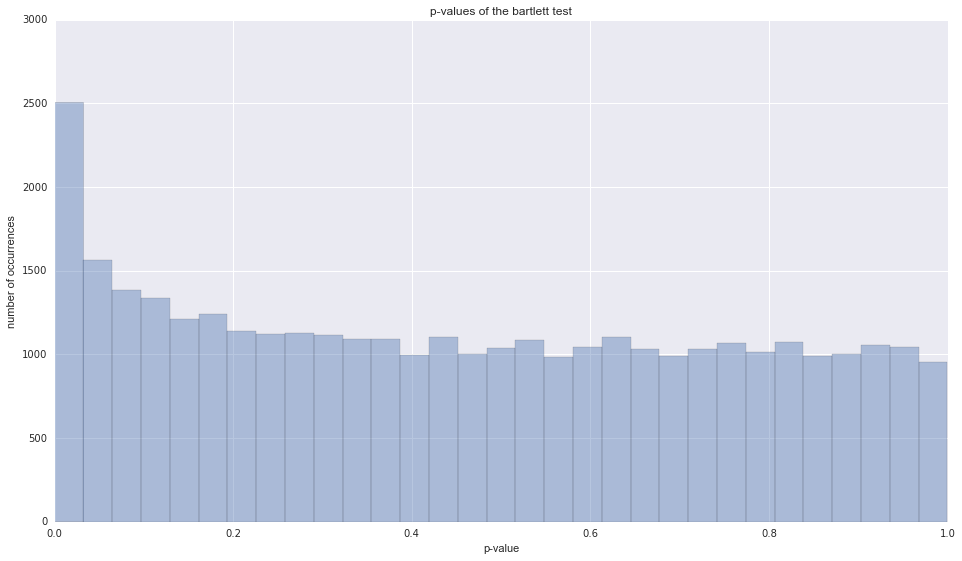

In [95]:
plt.figure(figsize=(16, 9))
plt.title('p-values of the bartlett test')
plt.xlabel('p-value')
plt.ylabel('number of occurrences')
sns.distplot(global_p_values, kde=False);

The null hypothesis of the bartlett test is that the variances are equal. Since we have a significant number of occurrences with a p-value of less than 0.05, we need to reject the null hypothesis and accept the alternative hypothesis. The variances are not equal.  

## Normal distribution
The next step is to check for normal distribution using the shapiro-wilk-test. 

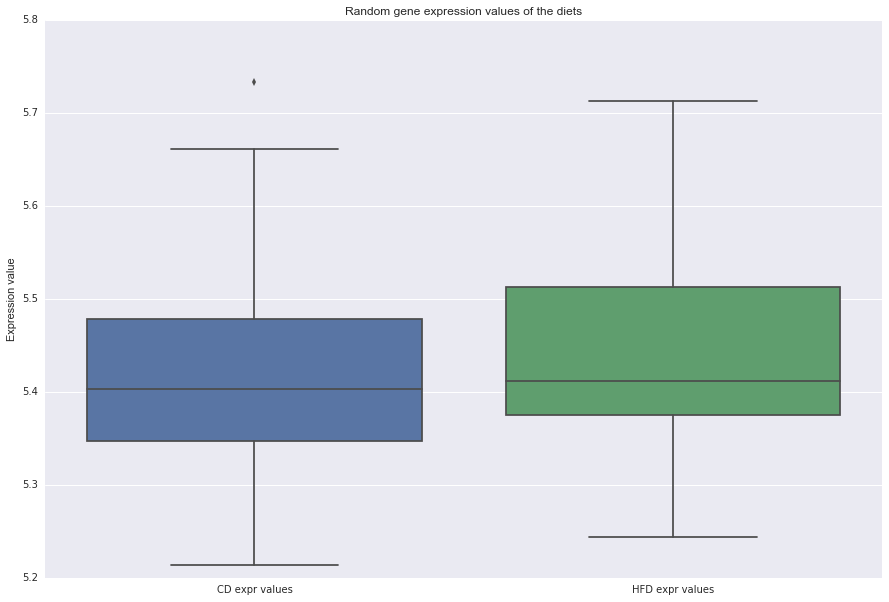

In [103]:
# Using the same gene randomly chosen above, make a Box plot for the corresponding CD and HFD sample and give 
# an interpretation
norm_data = pd.DataFrame({"HFD expr values" : sample_HFD_expr_values, 
                     "CD expr values" : sample_CD_expr_values})
plt.figure(figsize=(15, 10))
plt.title('Random gene expression values of the diets')
plt.ylabel('Expression value')
sns.boxplot(data=norm_data);

# Interpretation (depends on the random row..):
# The genes of the mice getting CD are on average stronger expressed than the genes of the mice getting CD. Also the 
# variance of CD is sligthly larger than the variance of HFD. 

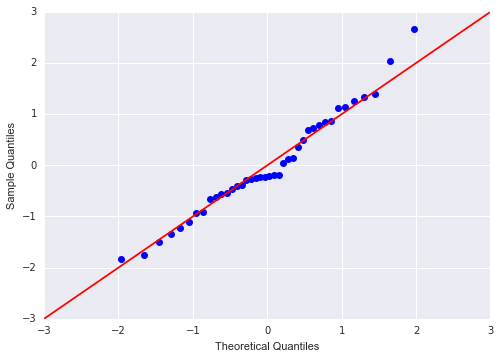

In [105]:
# just like in 2.2.1 make Q-Q plots for each sample (compare each to the theoretical normal distribution)
norm_BXD = zscore(sample_HFD_expr_values.dropna())
sm.qqplot(norm_BXD, line='45');

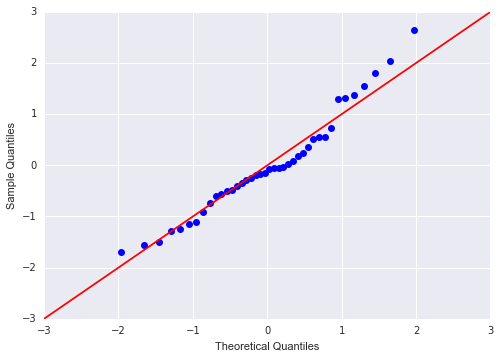

In [106]:
norm_CD = zscore(sample_CD_expr_values.dropna())
sm.qqplot(norm_CD, line='45');

Both qq-plots for the selected random row indicate the data is normally distributed.

In [107]:
# Apply an appropriate statistical test in order to figure out whether the samples are normally distributed

# shapiro wilk test for HFD
print(stats.shapiro(sample_HFD_expr_values))

# shapiro wilk for CD
print(stats.shapiro(sample_CD_expr_values))

(0.9747538566589355, 0.5017454028129578)
(0.9602739810943604, 0.17114891111850739)


The shapiro wilk test confirms that the data from this particular random row is indeed normally distributed. But again to be sure we need to asses the global situation:

In [108]:
def global_test_normal_distr(data_df_nd):
    ''' This function tests each row of the dataframe for normal distribution (=applies shapiro wilk test).
    
        data_df_nd: the dataframe to check for normal distribution
    
    '''
    
    # lists to store the result
    list_of_p_values_CD  = []
    list_of_p_values_HFD = []
    
    # iterate over the dataframe
    for row_nd in data_df_nd.index:
        
        # get the current row
        gene_nd = microarray_data.loc[row_nd]
        
        # BXD92_Liver_CD exists only for CD -> remove it 
        gene_nd_dropped = gene_nd.drop('BXD92_Liver_CD')

        # get the CD and BXD expression values
        sample_CD_expr_values_nd = gene_nd_dropped[51:]
        sample_HFD_expr_values_nd = gene_nd_dropped[10:50]
    
        # apply shapiro test:
        list_of_p_values_CD.append(stats.shapiro(sample_CD_expr_values_nd)[1])
        list_of_p_values_HFD.append(stats.shapiro(sample_HFD_expr_values_nd)[1])
        
    return list_of_p_values_CD, list_of_p_values_HFD 
        

In [109]:
normal_distr_CD_p_values, normal_distr_HFD_p_values = global_test_normal_distr(microarray_data)

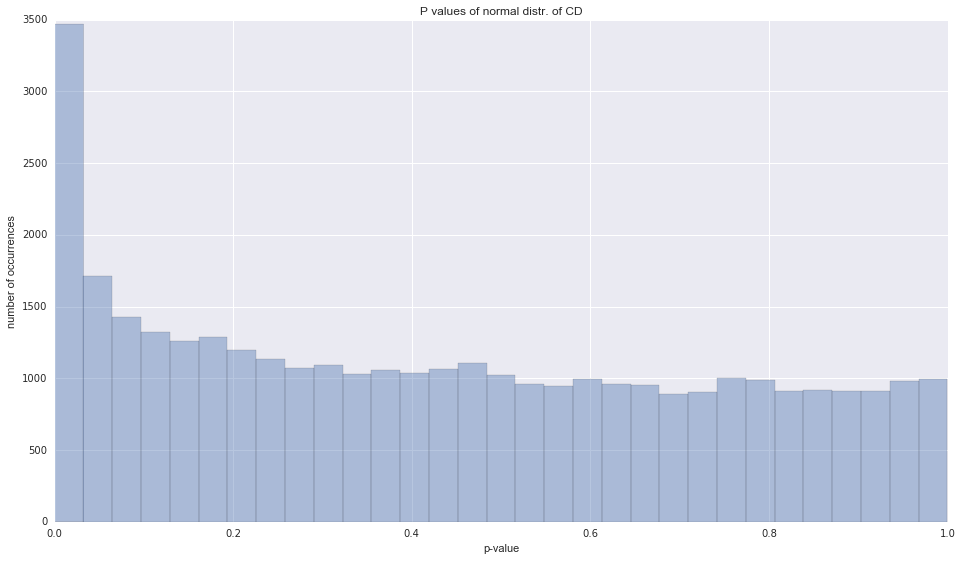

In [110]:
plt.figure(figsize=(16, 9))
sns.plt.xlabel('p-value')
sns.plt.ylabel('number of occurrences')
sns.plt.title('P values of normal distr. of CD')
sns.distplot(normal_distr_CD_p_values, kde=False);

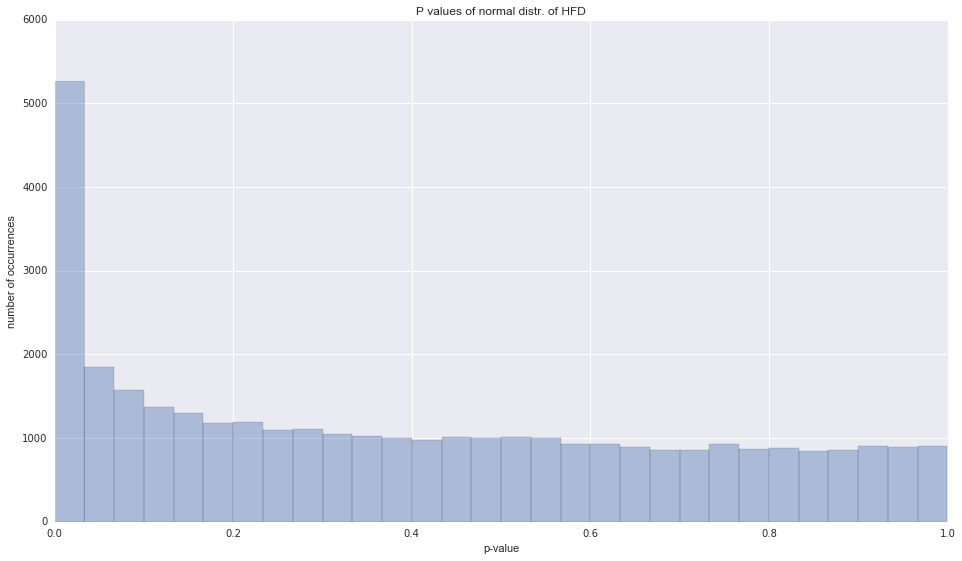

In [111]:
plt.figure(figsize=(16, 9))
sns.plt.xlabel('p-value')
sns.plt.ylabel('number of occurrences')
sns.plt.title('P values of normal distr. of HFD')
sns.distplot(normal_distr_HFD_p_values, kde=False);

The null hypothesis of the shapiro-wilk test is that the data is normally distributed. Since we have a significant number of occurrences with a p-value of less than 0.05, we need to reject the null hypothesis and accept the alternative hypothesis. The data is not normally distributed. 

## Differentially expressed genes

To find the differentially expressed genes we're going to apply the Mann–Whitney U test, because it does not require the assumption of normal distributions and equal variances. Our significance niveau will be 5%. 

In [36]:
def test_diff_expression(data_diff_expr, alpha=0.05):
    ''' This method tests the data_diff_expr dataframe for differential expression and returns the list of 
    differentially expressed genes with significance alpha.
    
        data_diff_expr: the dataframe to test
        alpha: the significance niveau
    '''
    
    # lists to store the results
    list_of_diff_expr_genes = []
    list_of_diff_expr_genes_p_values = []
    
    # iterate over the dataframe
    for row_diff_expr in range(data_diff_expr.shape[0]):
        
        # get the current row
        gene_diff_expr = data_diff_expr.iloc[row_diff_expr]
    
        # BXD92_Liver_CD exists only for CD -> remove it 
        gene_de_dropped = gene_diff_expr.drop('BXD92_Liver_CD')

        # get the CD and HFD expression values
        sample_CD_expr_values_de = gene_de_dropped[48:]
        sample_HFD_expr_values_de = gene_de_dropped[7:47]
        
        # apply mannwhitneyu test:
        list_of_diff_expr_genes_p_values.append(stats.mannwhitneyu(sample_CD_expr_values_de, 
                                                                   sample_HFD_expr_values_de)[1])
        
        # append the results to dataframe
        list_of_diff_expr_genes.append(data_diff_expr.index[row_diff_expr])

    # create a dataframe storing the results    
    return pd.DataFrame({"gene" : list_of_diff_expr_genes,
                        "pvalue" : list_of_diff_expr_genes_p_values}) 

In [112]:
diff_expressed_results = test_diff_expression(mean_values)
len(diff_expressed_results)

21834

In total we found 21834 differentialy expressed genes. 

## Multiple-testing correction

Because we're dealing with a pretty large dataset, some of our differentially expressed genes will be significant by chance. To deal with this issue one uses multiple-testing correction, where a corrected significance niveau $\alpha$ is calculated. 

In [39]:
def MHT_correction(resulting_df_2, alpha=0.1, method='bonferroni'):
    """ returns the significant genes:
    
        resulting_df: the df to analyze
        alpha: 
        method: the method to apply 
    """
    
    # get the size of the dataframe
    n = resulting_df_2.shape[0]
    
    # calculate the adjusted p-values
    if method is 'bonferroni':
        adjusted_p_value = alpha / n
    elif method is 'sidak':
        adjusted_p_value = 1 - ((1-alpha)**(float(1)/n))
        
    # get all values which p-values are smaller than the adjusted p-value    
    sig_results = resulting_df_2[resulting_df_2["pvalue"] < adjusted_p_value]
    
    return sig_results.sort_values(by = 'pvalue')

In [113]:
# correct with manual implemented bonferroni correction
corrected_genes = MHT_correction(diff_expressed_results, alpha=0.05)
print("There are " + str(len(corrected_genes)) + " differentially expressed genes using Bonferroni.")

There are 3096 differentially expressed genes using Bonferroni.


Bonferroni isn't the only multiple testing procedure, in fact there are much more. Since the results are highly dependent on the used multiple test, we're going to use and compare a lot of them :  

In [43]:
def mult_testing(testing_df):
    ''' This function applies different multiple testing procedures to the dataframe.
    
        testing_df: the dataframe to apply multiple testing to.
    '''
    
    # list of correction methods
    correction_methods = list(["sidak", "holm-sidak", "holm", "simes-hochberg", "hommel", "fdr_bh", "fdr_by", 
                          "fdr_tsbh", "fdr_tsbky"])
    
    # iterate over all correction methods
    for correction_method in correction_methods:
    
        # apply the test
        mult_test = multipletests(testing_df['pvalue'], method=correction_method)
        
        # get the adjusted p-values
        adjusted_p_values = mult_test[1]
        
        # create a new column and add the adjusted p-values
        testing_df[correction_method] = adjusted_p_values
    
    return testing_df    

In [44]:
mult_testing_result = mult_testing(diff_expressed_results)

The compare them visually, we need to rewrite the dataframe a little bit and are then able to simply use paco. 

In [114]:
# add a row with either numeric or factor as the first row
list1 = ["factor"]
list2 = ["numeric"]*10

# create a copy of the result_data_frame
paco = mult_testing_result.copy()

# add the two lists to the dataframe on pos -1
paco.loc[-1] = list1+list2

# shift all indices by one
paco.index = paco.index + 1

# sort by index
paco = paco.sort_index()

In [48]:
paco.to_csv("results/diff_expr_genes.csv", index=False)

<img src="figures/dayx_parallel_coords.png",width=1200,height=600>

In [49]:
print("Sidak: " + str(len(mult_testing_result[mult_testing_result['sidak'] < 0.05])))
print("Holm-Sidak: " + str(len(mult_testing_result[mult_testing_result['holm-sidak'] < 0.05])))
print("Holm: " + str(len(mult_testing_result[mult_testing_result['holm'] < 0.05])))
print("Simes-Hochberg: " + str(len(mult_testing_result[mult_testing_result['simes-hochberg'] < 0.05])))
print("Hommel: " + str(len(mult_testing_result[mult_testing_result['hommel'] < 0.05])))
print("FDR_BH: " + str(len(mult_testing_result[mult_testing_result['fdr_bh'] < 0.05])))
print("FDR_BY: " + str(len(mult_testing_result[mult_testing_result['fdr_by'] < 0.05])))
print("FDR_TSBH: " + str(len(mult_testing_result[mult_testing_result['fdr_tsbh'] < 0.05])))
print("FDR_TSBKY: " + str(len(mult_testing_result[mult_testing_result['fdr_tsbky'] < 0.05])))

Sidak: 3106
Holm-Sidak: 3181
Holm: 3164
Simes-Hochberg: 3164
Hommel: 3312
FDR_BH: 12183
FDR_BY: 7908
FDR_TSBH: 14340
FDR_TSBKY: 14144


Bonferroni is the most stringent method, returning 3096 genes. False discovery rate correction by TSBH is the least stringent method. It returns nearly the half of the dataset: 14340 genes. Three of the four FDR methods are pretty similar, because the formula differs only marginally. 

## Vulcano plots

A volcano plot can be used to visually identify interesting genes. It is constructed by plotting the negative log of the p value versus the log of the fold change between the two conditions. This results in data points with low p values appearing toward the top of the plot and data points with large magnitude fold changes appearing to the left/right of the plot.

In [53]:
def calculate_fold_change(data_df, diff_expr_df):
    ''' calculates the fold change from data df and adds it as a column to the diff_expr_df
    
        data_df: the dataframe containing the expression values
        diff_expressed_results: the dataframe containing all genes and their corresponding p-values from multiple tests
    '''

    # fold change: log2(E_1 / E_2) with E_1, E_2 expression values

    list_fold_change = []

    # iterate over dataframe
    for index, gene_row in mean_values.iterrows():
    
        # drop the BXD92 column
        dropped_df = gene_row.drop('BXD92_Liver_CD')
        
        # get the CD and HFD expression values
        CD_expr_values_ = dropped_df[7:47]
        HFD_expr_values_ = dropped_df[48:]
    
        # calculate mean for CD:
        mean_CD = CD_expr_values_.mean()
    
        # calculate mean for HFD:
        mean_HFD = HFD_expr_values_.mean()
    
        # append fold change to list
        list_fold_change.append(np.log2(mean_CD / mean_HFD))

    # create a copy of the diff_expr_df dataframe
    copy_data_df = diff_expr_df.copy()
    
    # add the column "log2 fold change" to the dataframe and use list_fold_change als values
    copy_data_df["log2 fold change"] = list_fold_change
    
    return copy_data_df

In [54]:
fold_change_df = calculate_fold_change(mean_values, diff_expressed_results)

In [55]:
fold_change_df.to_csv("results/diff_expr_genes_fold_change.csv", index=False)

In [57]:
def vulcano_plot(dataframe_to_plot, title='Volcano plot'):
    ''' This function draws a vulcano plot for the given dataframe dataframe_to_plot
    
        dataframe_to_plot: the dataframe to plot
        title: the title for the figure
    '''
    
    # get the log2 fold change
    X = dataframe_to_plot['log2 fold change']
    
    # get the -log 10 pvalues
    Y = -np.log10(dataframe_to_plot['pvalue'])
    
    # set title, labels, size
    plt.figure(figsize=(15, 10))
    plt.xlabel('log2 fold change')
    plt.ylabel('-log10 p-value')
    plt.title(title)
    
    # plot figure
    plt.scatter(X,Y)
    plt.show()

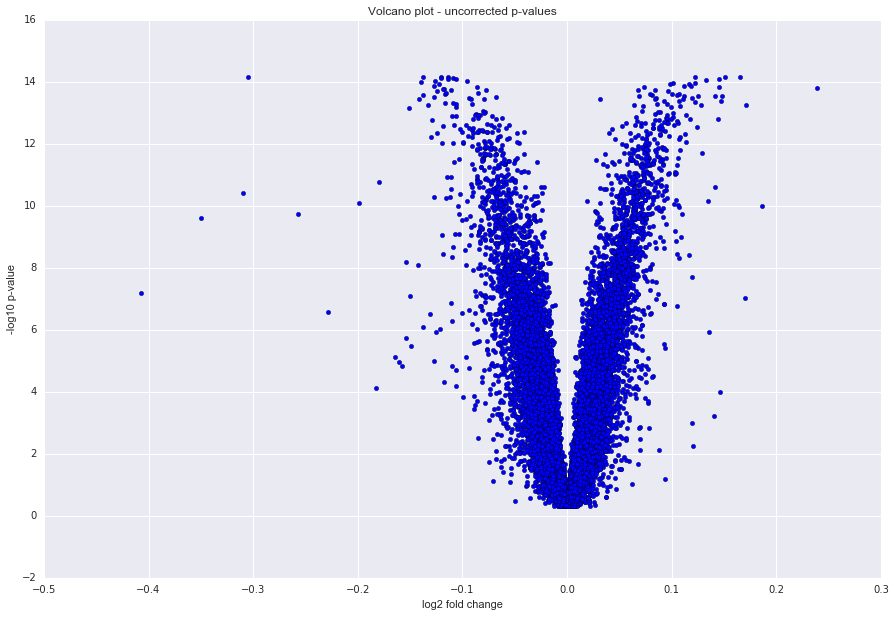

In [58]:
vulcano_plot(fold_change_df, 'Volcano plot - uncorrected p-values')

In [59]:
# do bonferroni correction on the data
fold_change_df_corrected = MHT_correction(fold_change_df, alpha=0.05)

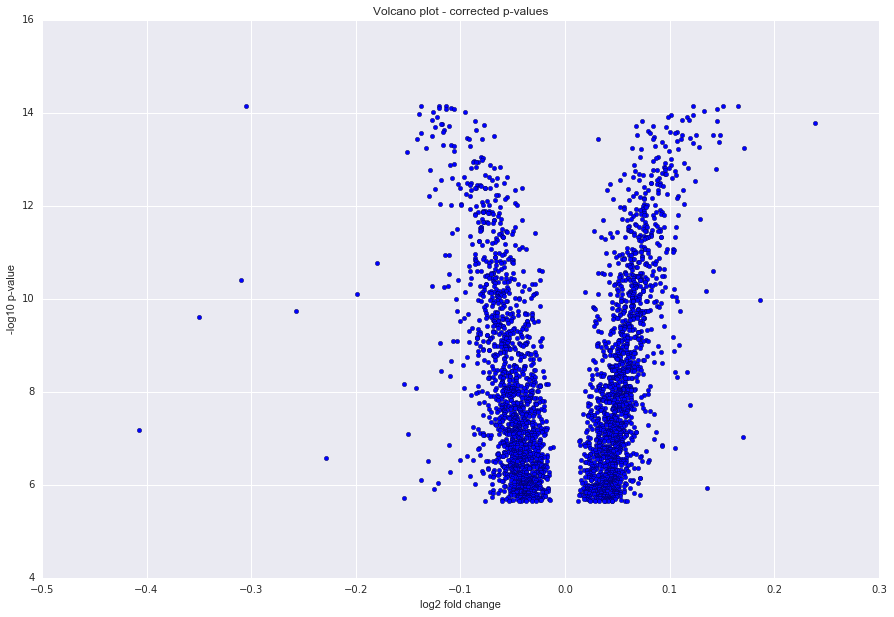

In [60]:
vulcano_plot(fold_change_df_corrected, 'Volcano plot - corrected p-values')

## Task 5: RNA-seq

RNA-Seq uses next-generation sequencing and can be used to measure gene expression. First the RNA
has to be isolated, purified and needs to be converted to cDNA. After the conversion the cDNA can be sequenced and
the resulting short-read sequences can be analysed. The most striking difference to microarrays is, that RNA-seq deals with discrete data, while microarrays deal with continous data.